# Method 3 - Best Ideas High Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

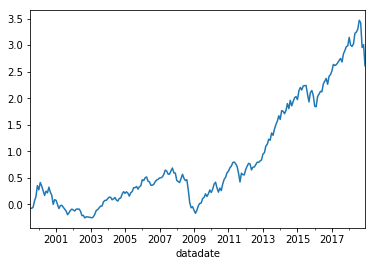

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.353265
2000-12-31   -0.196512
2001-12-31   -0.163211
2002-12-31   -0.166844
2003-12-31    0.419896
2004-12-31    0.151023
2005-12-31    0.090242
2006-12-31    0.088391
2007-12-31    0.081027
2008-12-31   -0.398771
2009-12-31    0.329042
2010-12-31    0.256745
2011-12-31   -0.025784
2012-12-31    0.181696
2013-12-31    0.452684
2014-12-31    0.135067
2015-12-31    0.007145
2016-12-31    0.128550
2017-12-31    0.157317
2018-12-31   -0.094253
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     463.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.78e-108
Time:                        12:48:59   Log-Likelihood:                 631.58
No. Observations:                 234   AIC:                            -1253.
Df Residuals:                     229   BIC:                            -1236.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.757      0.450      -0.001       0.003
mktrf          0.9985      0.031     32.538      0.000       0.938       1.059
me             0.3980      0.036     11.148      0.000       0.328       0.468
ia            -0.2210      0.054     -4.074      0.000      -0.328      -0.114
roe            0.2111      0.046      4.546      0.000       0.120       0.303
==============================================================================
Omnibus:                       61.755   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              459.729
Skew:                           0.782   Prob(JB):                    1.48e-100
Kurtosis:                       9.686   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     313.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-91
Time:                        12:48:59   Log-Likelihood:                 631.58
No. Observations:                 234   AIC:                            -1253.
Df Residuals:                     229   BIC:                            -1236.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.702      0.483      -0.002       0.003
mktrf          0.9985      0.039     25.460      0.000       0.922       1.075
me             0.3980      0.034     11.696      0.000       0.331       0.465
ia            -0.2210      0.101     -2.188      0.029      -0.419      -0.023
roe            0.2111      0.062      3.426      0.001       0.090       0.332
==============================================================================
Omnibus:                       61.755   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              459.729
Skew:                           0.782   Prob(JB):                    1.48e-100
Kurtosis:                       9.686   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     316.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.69e-92
Time:                        12:48:59   Log-Likelihood:                 631.58
No. Observations:                 234   AIC:                            -1253.
Df Residuals:                     229   BIC:                            -1236.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.738      0.460      -0.001       0.003
mktrf          0.9985      0.038     26.325      0.000       0.924       1.073
me             0.3980      0.031     12.666      0.000       0.336       0.460
ia            -0.2210      0.099     -2.243      0.025      -0.414      -0.028
roe            0.2111      0.061      3.458      0.001       0.091       0.331
==============================================================================
Omnibus:                       61.755   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              459.729
Skew:                           0.782   Prob(JB):                    1.48e-100
Kurtosis:                       9.686   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     316.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.36e-100
Time:                        12:48:59   Log-Likelihood:                 615.58
No. Observations:                 234   AIC:                            -1219.
Df Residuals:                     228   BIC:                            -1198.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.371      0.172      -0.001       0.004
mktrf          0.9506      0.033     28.809      0.000       0.886       1.016
smb            0.3903      0.044      8.965      0.000       0.305       0.476
hml           -0.1258      0.051     -2.451      0.015      -0.227      -0.025
rmw            0.0515      0.058      0.888      0.375      -0.063       0.166
cma           -0.0433      0.074     -0.587      0.558      -0.189       0.102
==============================================================================
Omnibus:                       53.118   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              453.716
Skew:                           0.561   Prob(JB):                     3.00e-99
Kurtosis:                       9.729   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     293.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.12e-97
Time:                        12:48:59   Log-Likelihood:                 615.58
No. Observations:                 234   AIC:                            -1219.
Df Residuals:                     228   BIC:                            -1198.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.325      0.185      -0.001       0.004
mktrf          0.9506      0.040     23.592      0.000       0.872       1.030
smb            0.3903      0.072      5.385      0.000       0.248       0.532
hml           -0.1258      0.065     -1.921      0.055      -0.254       0.003
rmw            0.0515      0.092      0.558      0.577      -0.130       0.233
cma           -0.0433      0.175     -0.247      0.805      -0.387       0.300
==============================================================================
Omnibus:                       53.118   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              453.716
Skew:                           0.561   Prob(JB):                     3.00e-99
Kurtosis:                       9.729   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     407.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.68e-111
Time:                        12:48:59   Log-Likelihood:                 615.58
No. Observations:                 234   AIC:                            -1219.
Df Residuals:                     228   BIC:                            -1198.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.378      0.168      -0.001       0.004
mktrf          0.9506      0.041     23.333      0.000       0.871       1.030
smb            0.3903      0.075      5.215      0.000       0.244       0.537
hml           -0.1258      0.063     -2.001      0.045      -0.249      -0.003
rmw            0.0515      0.100      0.513      0.608      -0.145       0.248
cma           -0.0433      0.177     -0.245      0.807      -0.390       0.304
==============================================================================
Omnibus:                       53.118   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              453.716
Skew:                           0.561   Prob(JB):                     3.00e-99
Kurtosis:                       9.729   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     548.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.10e-116
Time:                        12:49:00   Log-Likelihood:                 649.35
No. Observations:                 234   AIC:                            -1289.
Df Residuals:                     229   BIC:                            -1271.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.681      0.497      -0.001       0.003
mktrf          1.0431      0.026     39.830      0.000       0.991       1.095
smb            0.2802      0.033      8.573      0.000       0.216       0.345
hml           -0.0100      0.032     -0.308      0.758      -0.074       0.054
umd            0.1941      0.021      9.110      0.000       0.152       0.236
==============================================================================
Omnibus:                       31.430   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.795
Skew:                           0.405   Prob(JB):                     1.78e-28
Kurtosis:                       6.529   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     424.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.12e-104
Time:                        12:49:00   Log-Likelihood:                 649.35
No. Observations:                 234   AIC:                            -1289.
Df Residuals:                     229   BIC:                            -1271.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.746      0.456      -0.001       0.003
mktrf          1.0431      0.045     23.072      0.000       0.954       1.132
smb            0.2802      0.054      5.218      0.000       0.175       0.385
hml           -0.0100      0.041     -0.242      0.809      -0.091       0.071
umd            0.1941      0.044      4.394      0.000       0.108       0.281
==============================================================================
Omnibus:                       31.430   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.795
Skew:                           0.405   Prob(JB):                     1.78e-28
Kurtosis:                       6.529   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     609.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.03e-121
Time:                        12:49:00   Log-Likelihood:                 649.35
No. Observations:                 234   AIC:                            -1289.
Df Residuals:                     229   BIC:                            -1271.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.779      0.436      -0.001       0.002
mktrf          1.0431      0.045     23.134      0.000       0.955       1.131
smb            0.2802      0.062      4.518      0.000       0.159       0.402
hml           -0.0100      0.035     -0.284      0.777      -0.079       0.059
umd            0.1941      0.042      4.658      0.000       0.112       0.276
==============================================================================
Omnibus:                       31.430   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.795
Skew:                           0.405   Prob(JB):                     1.78e-28
Kurtosis:                       6.529   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     180.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.50e-48
Time:                        12:49:00   Log-Likelihood:                 296.08
No. Observations:                 120   AIC:                            -582.2
Df Residuals:                     115   BIC:                            -568.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.797e-05      0.002      0.009      0.993      -0.004       0.004
mktrf          1.0455      0.054     19.349      0.000       0.938       1.153
me             0.4188      0.053      7.848      0.000       0.313       0.525
ia            -0.2877      0.084     -3.443      0.001      -0.453      -0.122
roe            0.3277      0.074      4.431      0.000       0.181       0.474
==============================================================================
Omnibus:                       26.188   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.465
Skew:                           0.685   Prob(JB):                     1.02e-19
Kurtosis:                       6.952   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     130.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.71e-42
Time:                        12:49:00   Log-Likelihood:                 296.08
No. Observations:                 120   AIC:                            -582.2
Df Residuals:                     115   BIC:                            -568.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.797e-05      0.002      0.008      0.993      -0.004       0.004
mktrf          1.0455      0.064     16.360      0.000       0.920       1.171
me             0.4188      0.041     10.319      0.000       0.339       0.498
ia            -0.2877      0.136     -2.112      0.035      -0.555      -0.021
roe            0.3277      0.069      4.721      0.000       0.192       0.464
==============================================================================
Omnibus:                       26.188   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.465
Skew:                           0.685   Prob(JB):                     1.02e-19
Kurtosis:                       6.952   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     139.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.70e-43
Time:                        12:49:00   Log-Likelihood:                 296.08
No. Observations:                 120   AIC:                            -582.2
Df Residuals:                     115   BIC:                            -568.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.797e-05      0.002      0.009      0.993      -0.004       0.004
mktrf          1.0455      0.054     19.229      0.000       0.939       1.152
me             0.4188      0.036     11.698      0.000       0.349       0.489
ia            -0.2877      0.133     -2.164      0.030      -0.548      -0.027
roe            0.3277      0.047      6.921      0.000       0.235       0.421
==============================================================================
Omnibus:                       26.188   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.465
Skew:                           0.685   Prob(JB):                     1.02e-19
Kurtosis:                       6.952   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     110.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.42e-42
Time:                        12:49:00   Log-Likelihood:                 283.14
No. Observations:                 120   AIC:                            -554.3
Df Residuals:                     114   BIC:                            -537.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.852      0.396      -0.003       0.007
mktrf          0.9571      0.064     15.015      0.000       0.831       1.083
smb            0.3934      0.072      5.450      0.000       0.250       0.536
hml           -0.1724      0.088     -1.949      0.054      -0.348       0.003
rmw            0.1006      0.104      0.964      0.337      -0.106       0.307
cma           -0.0314      0.114     -0.274      0.784      -0.258       0.195
==============================================================================
Omnibus:                       18.816   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.039
Skew:                           0.445   Prob(JB):                     2.49e-13
Kurtosis:                       6.289   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     99.06
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.94e-40
Time:                        12:49:00   Log-Likelihood:                 283.14
No. Observations:                 120   AIC:                            -554.3
Df Residuals:                     114   BIC:                            -537.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.822      0.411      -0.003       0.007
mktrf          0.9571      0.074     12.926      0.000       0.812       1.102
smb            0.3934      0.105      3.760      0.000       0.188       0.599
hml           -0.1724      0.091     -1.903      0.057      -0.350       0.005
rmw            0.1006      0.134      0.752      0.452      -0.162       0.363
cma           -0.0314      0.227     -0.138      0.890      -0.477       0.414
==============================================================================
Omnibus:                       18.816   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.039
Skew:                           0.445   Prob(JB):                     2.49e-13
Kurtosis:                       6.289   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     112.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.75e-42
Time:                        12:49:00   Log-Likelihood:                 283.14
No. Observations:                 120   AIC:                            -554.3
Df Residuals:                     114   BIC:                            -537.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.849      0.396      -0.003       0.006
mktrf          0.9571      0.073     13.052      0.000       0.813       1.101
smb            0.3934      0.108      3.649      0.000       0.182       0.605
hml           -0.1724      0.085     -2.020      0.043      -0.340      -0.005
rmw            0.1006      0.145      0.696      0.486      -0.183       0.384
cma           -0.0314      0.228     -0.138      0.891      -0.478       0.415
==============================================================================
Omnibus:                       18.816   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.039
Skew:                           0.445   Prob(JB):                     2.49e-13
Kurtosis:                       6.289   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     229.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.81e-54
Time:                        12:49:00   Log-Likelihood:                 308.68
No. Observations:                 120   AIC:                            -607.4
Df Residuals:                     115   BIC:                            -593.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      1.032      0.304      -0.002       0.005
mktrf          1.0993      0.043     25.650      0.000       1.014       1.184
smb            0.2168      0.049      4.442      0.000       0.120       0.313
hml           -0.0281      0.049     -0.575      0.566      -0.125       0.069
umd            0.2437      0.030      8.087      0.000       0.184       0.303
==============================================================================
Omnibus:                        6.741   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.034   Jarque-Bera (JB):               11.063
Skew:                           0.131   Prob(JB):                      0.00396
Kurtosis:                       4.464   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     203.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.77e-51
Time:                        12:49:00   Log-Likelihood:                 308.68
No. Observations:                 120   AIC:                            -607.4
Df Residuals:                     115   BIC:                            -593.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.223      0.221      -0.001       0.005
mktrf          1.0993      0.063     17.356      0.000       0.975       1.223
smb            0.2168      0.063      3.446      0.001       0.093       0.340
hml           -0.0281      0.050     -0.560      0.575      -0.127       0.070
umd            0.2437      0.053      4.592      0.000       0.140       0.348
==============================================================================
Omnibus:                        6.741   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.034   Jarque-Bera (JB):               11.063
Skew:                           0.131   Prob(JB):                      0.00396
Kurtosis:                       4.464   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     338.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.35e-62
Time:                        12:49:00   Log-Likelihood:                 308.68
No. Observations:                 120   AIC:                            -607.4
Df Residuals:                     115   BIC:                            -593.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.357      0.175      -0.001       0.004
mktrf          1.0993      0.054     20.172      0.000       0.992       1.206
smb            0.2168      0.070      3.103      0.002       0.080       0.354
hml           -0.0281      0.039     -0.730      0.466      -0.104       0.047
umd            0.2437      0.044      5.562      0.000       0.158       0.330
==============================================================================
Omnibus:                        6.741   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.034   Jarque-Bera (JB):               11.063
Skew:                           0.131   Prob(JB):                      0.00396
Kurtosis:                       4.464   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     637.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.34e-74
Time:                        12:49:00   Log-Likelihood:                 384.85
No. Observations:                 114   AIC:                            -759.7
Df Residuals:                     109   BIC:                            -746.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.622      0.010       0.001       0.004
mktrf          0.9522      0.025     38.283      0.000       0.903       1.002
me             0.3662      0.038      9.535      0.000       0.290       0.442
ia            -0.1346      0.053     -2.527      0.013      -0.240      -0.029
roe           -0.0424      0.047     -0.905      0.367      -0.135       0.050
==============================================================================
Omnibus:                        2.793   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.311
Skew:                           0.337   Prob(JB):                        0.315
Kurtosis:                       3.182   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     961.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.50e-84
Time:                        12:49:00   Log-Likelihood:                 384.85
No. Observations:                 114   AIC:                            -759.7
Df Residuals:                     109   BIC:                            -746.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.390      0.017       0.000       0.004
mktrf          0.9522      0.020     47.548      0.000       0.913       0.991
me             0.3662      0.045      8.177      0.000       0.278       0.454
ia            -0.1346      0.058     -2.331      0.020      -0.248      -0.021
roe           -0.0424      0.042     -1.005      0.315      -0.125       0.040
==============================================================================
Omnibus:                        2.793   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.311
Skew:                           0.337   Prob(JB):                        0.315
Kurtosis:                       3.182   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1018.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.66e-85
Time:                        12:49:00   Log-Likelihood:                 384.85
No. Observations:                 114   AIC:                            -759.7
Df Residuals:                     109   BIC:                            -746.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.176      0.030       0.000       0.004
mktrf          0.9522      0.019     49.747      0.000       0.915       0.990
me             0.3662      0.043      8.493      0.000       0.282       0.451
ia            -0.1346      0.054     -2.493      0.013      -0.240      -0.029
roe           -0.0424      0.037     -1.136      0.256      -0.115       0.031
==============================================================================
Omnibus:                        2.793   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.311
Skew:                           0.337   Prob(JB):                        0.315
Kurtosis:                       3.182   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     522.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.30e-74
Time:                        12:49:00   Log-Likelihood:                 386.69
No. Observations:                 114   AIC:                            -761.4
Df Residuals:                     108   BIC:                            -745.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.535      0.128      -0.000       0.003
mktrf          0.9601      0.023     40.942      0.000       0.914       1.007
smb            0.3744      0.038      9.836      0.000       0.299       0.450
hml           -0.0922      0.049     -1.899      0.060      -0.188       0.004
rmw           -0.0738      0.059     -1.241      0.217      -0.192       0.044
cma           -0.0731      0.075     -0.969      0.335      -0.223       0.076
==============================================================================
Omnibus:                        3.008   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.222   Jarque-Bera (JB):                2.654
Skew:                           0.372   Prob(JB):                        0.265
Kurtosis:                       3.075   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     566.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.77e-76
Time:                        12:49:00   Log-Likelihood:                 386.69
No. Observations:                 114   AIC:                            -761.4
Df Residuals:                     108   BIC:                            -745.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.432      0.152      -0.000       0.003
mktrf          0.9601      0.024     40.519      0.000       0.914       1.006
smb            0.3744      0.047      8.049      0.000       0.283       0.466
hml           -0.0922      0.032     -2.914      0.004      -0.154      -0.030
rmw           -0.0738      0.053     -1.399      0.162      -0.177       0.030
cma           -0.0731      0.069     -1.063      0.288      -0.208       0.062
==============================================================================
Omnibus:                        3.008   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.222   Jarque-Bera (JB):                2.654
Skew:                           0.372   Prob(JB):                        0.265
Kurtosis:                       3.075   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     795.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.84e-83
Time:                        12:49:00   Log-Likelihood:                 386.69
No. Observations:                 114   AIC:                            -761.4
Df Residuals:                     108   BIC:                            -745.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.355      0.175      -0.001       0.003
mktrf          0.9601      0.023     42.581      0.000       0.916       1.004
smb            0.3744      0.044      8.511      0.000       0.288       0.461
hml           -0.0922      0.025     -3.695      0.000      -0.141      -0.043
rmw           -0.0738      0.057     -1.293      0.196      -0.186       0.038
cma           -0.0731      0.064     -1.136      0.256      -0.199       0.053
==============================================================================
Omnibus:                        3.008   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.222   Jarque-Bera (JB):                2.654
Skew:                           0.372   Prob(JB):                        0.265
Kurtosis:                       3.075   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     644.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.50e-75
Time:                        12:49:00   Log-Likelihood:                 385.45
No. Observations:                 114   AIC:                            -760.9
Df Residuals:                     109   BIC:                            -747.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.054      0.294      -0.001       0.003
mktrf          0.9734      0.023     41.517      0.000       0.927       1.020
smb            0.3896      0.037     10.657      0.000       0.317       0.462
hml           -0.0606      0.038     -1.610      0.110      -0.135       0.014
umd            0.0288      0.028      1.014      0.313      -0.027       0.085
==============================================================================
Omnibus:                        1.878   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                1.599
Skew:                           0.289   Prob(JB):                        0.449
Kurtosis:                       3.040   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     618.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.54e-74
Time:                        12:49:00   Log-Likelihood:                 385.45
No. Observations:                 114   AIC:                            -760.9
Df Residuals:                     109   BIC:                            -747.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.956      0.339      -0.001       0.003
mktrf          0.9734      0.023     41.485      0.000       0.927       1.019
smb            0.3896      0.040      9.805      0.000       0.312       0.467
hml           -0.0606      0.036     -1.682      0.093      -0.131       0.010
umd            0.0288      0.026      1.104      0.270      -0.022       0.080
==============================================================================
Omnibus:                        1.878   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                1.599
Skew:                           0.289   Prob(JB):                        0.449
Kurtosis:                       3.040   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     887.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.66e-82
Time:                        12:49:00   Log-Likelihood:                 385.45
No. Observations:                 114   AIC:                            -760.9
Df Residuals:                     109   BIC:                            -747.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.914      0.361      -0.001       0.003
mktrf          0.9734      0.021     46.873      0.000       0.933       1.014
smb            0.3896      0.035     11.111      0.000       0.321       0.458
hml           -0.0606      0.031     -1.929      0.054      -0.122       0.001
umd            0.0288      0.025      1.164      0.245      -0.020       0.077
==============================================================================
Omnibus:                        1.878   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                1.599
Skew:                           0.289   Prob(JB):                        0.449
Kurtosis:                       3.040   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""